In [1]:
import matplotlib.pyplot as plt
from matplotlib import mlab, rcParams, dates
%matplotlib inline
import numpy as np
from scipy import interpolate, spatial, stats
import datetime
from shapely.geometry import Polygon, Point
import scipy.signal as signal
import pandas as pd

# Minute data

Temperature data with one-minute resolution is provided from four schools in the format of decimal days as discussed below and the second column is temperature in degrees Celcius.

Present the data, and characterize it using techniques discussed in class. Obvious things to do are just plot the time series, find means, PDFs, spectra. More involved projects will present correlations between the different stations (thats why you have 4!). What differences and patterns can you find between the four stations, and can you explain using your knowledge of the local climate?

In [2]:
# Minute data, 4 Schools
mins, dc = np.loadtxt('/Users/kawebb/P411_git/MinuteData/DeepCoveNew.txt', unpack=True)
jb = np.loadtxt('/Users/kawebb/P411_git/MinuteData/JamesBayNew.txt', usecols=([1]), unpack=True)
jm = np.loadtxt('/Users/kawebb/P411_git/MinuteData/JohnMuirNew.txt', usecols=([1]), unpack=True)
uv = np.loadtxt('/Users/kawebb/P411_git/MinuteData/UVicISCNew.txt', usecols=([1]), unpack=True)

### Linear interpolation

In [4]:
# fill in nan values with linear interpolation

def interp(data, rmean=False):
    # 1d interpolation to fill in nan values
    ok = -np.isnan(data)
    xp = ok.ravel().nonzero()[0]
    fp = data[-np.isnan(data)]
    x  = np.isnan(data).ravel().nonzero()[0]
    data[np.isnan(data)] = np.interp(x, xp, fp)
    if rmean:
        data -= np.mean(data)  # remove mean
    return data

dc = interp(dc, rmean=False)
jb = interp(jb, rmean=False)
jm = interp(jm, rmean=False)
uv = interp(uv, rmean=False)

/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


### Time series

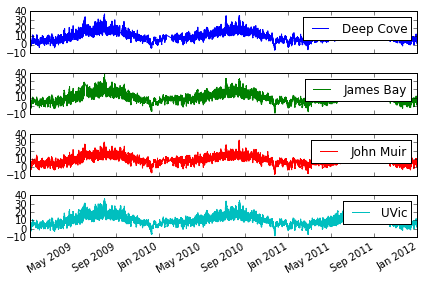

In [4]:
#latexify(columns=2)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True)#, figsize=(10,5))

ldc = ax1.plot_date(mins, dc, '-b', label='Deep Cove') ; ax1.legend()
ljb = ax2.plot_date(mins, jb, '-g', label='James Bay') ; ax2.legend()
ljm = ax3.plot_date(mins, jm, '-r', label='John Muir') ; ax3.legend()
luv = ax4.plot_date(mins, uv, '-c', label='UVic') ; ax4.legend()

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)

fig.autofmt_xdate()
plt.tight_layout()
#plt.savefig('figures/min_timeseries.png')

#fig = plt.figure()
#ax = fig.add_subplot(111)    # The big subplot
# Turn off axis lines and ticks of the big subplot
#ax.spines['top'].set_color('none')
#ax.spines['bottom'].set_color('none')
#ax.spines['left'].set_color('none')
#ax.spines['right'].set_color('none')
#ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
# Set common labels
#ax.set_ylabel(r'Temperature [$^\circ$C]')
#plt.savefig('figures/temp_label.png')

There seems to be a lot of noise due to daily fluctuations that obscure the yearly patterns. This can be improved by filtering the data with an elliptical low pass filter, with a stopband of ~ 3.5/day

### Low-pass filter

In [5]:
### Low-pass filter to see yearly patterns and suppress daily correlations
ts = 60.*24

def low_pass(data, ts, stopband=3.5):
    df = 1./(stopband*ts)
    wp = 0.7*df
    ws = 0.9*df
    n, fn = signal.ellipord(wp, ws, 0.5, 20.)
    b, a = signal.ellip(n, 0.5, 20., fn)
    fdata = signal.lfilter(b, a, data)
    #f = signal.filtfilt(b,a,dc)
    return fdata

fdc = low_pass(dc, ts)
fjb = low_pass(jb, ts)
fjm = low_pass(jm, ts)
fuv = low_pass(uv, ts)

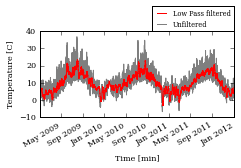

In [15]:
#latexify(columns=1)
fig, ax = plt.subplots()
ax.plot_date(mins, fdc, 'r-', zorder=1, label='Low Pass filtered')
ax.plot_date(mins, dc, 'k-', alpha=0.5, zorder=0, label='Unfiltered')
lgd = ax.legend(bbox_to_anchor=[1.015,1.33], fontsize='small')
ax.set_ylabel('Temperature [C]') ; ax.set_xlabel('Time [min]')
fig.autofmt_xdate()
plt.tight_layout()
#plt.savefig('figures/min_lowpass.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

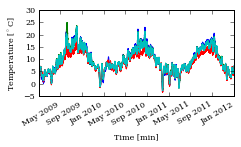

In [17]:
#latexify(columns=1)
fig, ax = plt.subplots(1,1)

ax.plot_date(mins, fdc, 'b-', zorder=1, label='Deep Cove')#, alpha=0.5)
ax.plot_date(mins, fjb, 'g-', zorder=1, label='James Bay')#, alpha=0.5)
ax.plot_date(mins, fjm, 'r-', zorder=1, label='John Muir')#, alpha=0.5)
ax.plot_date(mins, fuv, 'c-', zorder=1, label='UVic')#, alpha=0.5)

#ax.legend(fontsize='small')
ax.set_ylabel(r'Temperature [$^\circ$C]') ; ax.set_xlabel('Time [min]')
fig.autofmt_xdate()
plt.ylim(-5, 30)
plt.tight_layout()
#plt.savefig('figures/min_lowpassall.png')

With the time series smoothed, the temperature difference between summer and winter is much more obvious, as is expected for more nothern latitudes. 

It also seems that John Muir is consistnetly cooler in the summer than the other locations, and warmer in the winter. 
** Look at the at the pdfs of the yearly temperature data, calculate the univariate statistics to confirm this. **

### Probability density functions

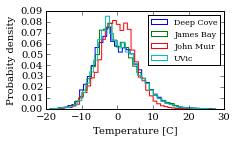

In [62]:
#latexify(columns=1)

bins=40

fig, ax = plt.subplots(1,1)
ax.hist(dc, bins, normed=True, histtype='step', label='Deep Cove')
ax.hist(jb, bins, normed=True, histtype='step', label='James Bay')
ax.hist(jm, bins, normed=True, histtype='step', label='John Muir')
ax.hist(uv, bins, normed=True, histtype='step', label='UVic')

ax.legend(loc=1,fontsize='8')
ax.set_xlabel('Temperature [C]')
ax.set_ylabel('Probabity density')

plt.tight_layout()
plt.savefig('figures/min_pdf.png')

Deep cove, James bay, UVic all look very similar, with asymmetrical PDFs, leaning towards colder temperatures. John Muir seem to have a much more symmetric PDF

### Univaritate statistics

In [42]:
### REIMPORT DATA to make sure mean not subtracted
#dc = interp(dc, rmean=False)
#jb = interp(jb, rmean=False)
#jm = interp(jm, rmean=False)
#uv = interp(uv, rmean=False)

print 'Station & Mean & Stdev & Skew & Kurtosis \\\\'
data = [dc, jb, jm, uv]
labels = ['Deep Cove', 'James Bay', 'John Muir', 'UVic']
for i,datum in enumerate(data):
    print '{} & {} & {} & {} & {} \\\\'.format(
        labels[i], np.mean(datum), np.std(datum), stats.skew(datum), stats.kurtosis(datum))

Station & Mean & Stdev & Skew & Kurtosis \\
Deep Cove & 10.3016300448 & 5.98099047791 & 0.443614320919 & 0.132772732286 \\
James Bay & 10.3107251853 & 5.83675368414 & 0.480090212186 & 0.228559531715 \\
John Muir & 9.11998334356 & 4.8364971532 & 0.0638702008621 & 0.140581890246 \\
UVic & 10.2371553568 & 5.70055093019 & 0.491206670657 & 0.287881662199 \\


The mean temperatuer of John Muir is in fact lower, and with a smaller mean and much smaller skew, which agress with the differences in the PDFs

### Power spectra and cross correlation

In [5]:
### Power spectral density
Nfft = 2048*12
dt = 60.
args = {'NFFT':Nfft, 'Fs':1./dt, 'noverlap':Nfft/2., 'window':mlab.window_hanning}

def specdensity(x, args, y=None):
    px, f = mlab.psd(x, **args)
    if y is not None:
        py, f = mlab.psd(y, **args)
        pxy, ff = mlab.csd(x, y, **args)
        return px, py, pxy, f
    else:
        return px, f
    
Pdc, Pjb, Pdcjb, f = specdensity(dc, args, jb)
Pjm, Puv, Pjmuv, f = specdensity(jm, args, uv)

Pdcjm, ff = mlab.csd(dc, jm, **args)
Pdcuv, ff = mlab.csd(dc, uv, **args)
Pjbjm, ff = mlab.csd(jb, jm, **args)
Pjbuv, ff = mlab.csd(jb, uv, **args)

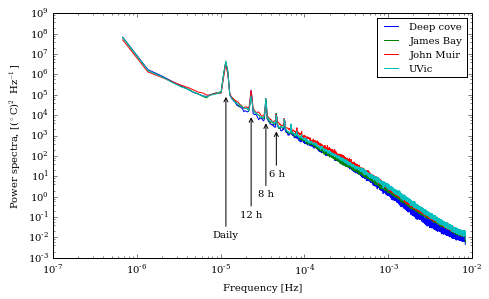

In [29]:
#latexify(columns=2)

yr = 3600.*24.*365.
day = 3600.*24.
h12 = 3600.*24./2.
h8 = 3600.*24./3.
h6 = 3600.*24./4.

#plt.axvline(1./day, color='k', ls=':')
plt.loglog(f, np.abs(Pdc), '-b', label='Deep cove')#, alpha=0.5)
plt.loglog(f, np.abs(Pjb), '-g', label='James Bay')#, alpha=0.5)
plt.loglog(f, np.abs(Pjm), '-r', label='John Muir')#, alpha=0.5)
plt.loglog(f, np.abs(Puv), '-c', label='UVic')#, alpha=0.5)
plt.xlabel('Frequency [Hz]') ; plt.ylabel('Power spectra, [($^\circ$C)$^2$ Hz$^{-1}$]')
plt.legend(loc=1)

plt.annotate('Daily', xy=(1./day, 1.e5),  xycoords='data', xytext=(1./day, 1.e-2), textcoords='data', 
            horizontalalignment='center', arrowprops=dict(arrowstyle="->"))
plt.annotate('12 h', xy=(1./h12, 1.e4),  xycoords='data', xytext=(1./h12, 1.e-1), textcoords='data', 
            horizontalalignment='center', arrowprops=dict(arrowstyle="->"))
plt.annotate('8 h', xy=(1./h8, 5.e3),  xycoords='data', xytext=(1./h8, 1.e-0), textcoords='data', 
            horizontalalignment='center', arrowprops=dict(arrowstyle="->"))
plt.annotate('6 h', xy=(1./h6, 2.e3),  xycoords='data', xytext=(1./h6, 1.e1), textcoords='data', 
            horizontalalignment='center', arrowprops=dict(arrowstyle="->"))

plt.tight_layout()
#plt.savefig('figures/min_powspec.png')

# We see a clear daily signal in the spectrum, and likely an annual signal too. 
# The spikes at higher frequencies are at harmonics of the daily frequency, and 
# are due to the fact that the temperature signal is not a precise sine-wave.

### hanning window doesnt sample low frequency, which is why you dont see the yearly peak

(50.0, 8000000.0)

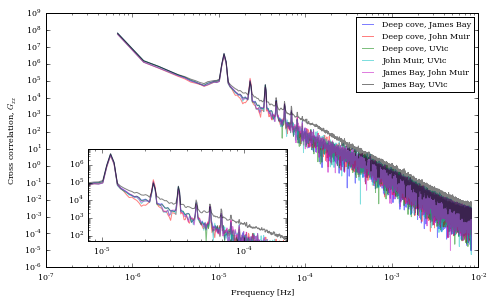

In [20]:
### REplot with inset of zoomed in region around peaks
latexify(columns=2)

# main axis
plt.loglog(f, np.abs(Pdcjb), '-b', label='Deep cove, James Bay', alpha=0.5)
plt.loglog(f, np.abs(Pdcjm), '-r', label='Deep cove, John Muir', alpha=0.5)
plt.loglog(f, np.abs(Pdcuv), '-g', label='Deep cove, UVic', alpha=0.5)
plt.loglog(f, np.abs(Pjmuv), '-c', label='John Muir, UVic', alpha=0.5)
plt.loglog(f, np.abs(Pjbjm), '-m', label='James Bay, John Muir', alpha=0.5)
plt.loglog(f, np.abs(Pjbuv), '-k', label='James Bay, UVic', alpha=0.5)
plt.xlabel('Frequency [Hz]') ; plt.ylabel('Cross correlation, $G_{xx}$')
plt.legend()
plt.tight_layout()

# this is an inset axes over the main axes
rect = [.18, .21, .4, .3]  # [left, bottom, width, height]
a = plt.axes(rect, axisbg='w')
plt.loglog(f, np.abs(Pdcjb), '-b', label='Deep cove, James Bay', alpha=0.5)
plt.loglog(f, np.abs(Pdcjm), '-r', label='Deep cove, John Muir', alpha=0.5)
plt.loglog(f, np.abs(Pdcuv), '-g', label='Deep cove, UVic', alpha=0.5)
plt.loglog(f, np.abs(Pjmuv), '-c', label='John Muir, UVic', alpha=0.5)
plt.loglog(f, np.abs(Pjbjm), '-m', label='James Bay, John Muir', alpha=0.5)
plt.loglog(f, np.abs(Pjbuv), '-k', label='James Bay, UVic', alpha=0.5)
plt.xlim(8e-6,2e-4) ; plt.ylim(5e1, 8e6)
#plt.xticks([]) ; plt.yticks([])  # Removes labels on the inset



#plt.savefig('figures/min_crosscorr.png')

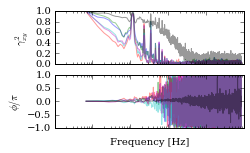

In [9]:
#latexify(columns=1)

gammasq_dcjb = np.abs(Pdcjb)**2/(Pdc*Pjb)
gammasq_dcjm = np.abs(Pdcjm)**2/(Pdc*Pjm)
gammasq_dcuv = np.abs(Pdcuv)**2/(Pdc*Puv)
gammasq_jbjm = np.abs(Pjbjm)**2/(Pjm*Pjb)
gammasq_jbuv = np.abs(Pjbuv)**2/(Puv*Pjb)
gammasq_jmuv = np.abs(Pjmuv)**2/(Pjm*Puv)

gamma = [gammasq_dcjb, gammasq_dcjm, gammasq_dcuv, gammasq_jmuv, gammasq_jbjm, gammasq_jbuv]
Ccs = [Pdcjb, Pdcjm, Pdcuv, Pjmuv, Pjbjm, Pjbuv]
labels=['Deep cove, James Bay', 'Deep cove, John Muir', 'Deep Cove, UVic', 'John Muir, UVic', 'James Bay, John Muir', 
        'James Bay, UVic']
labels2=['D.C., J.B.', 'D.C., J.M.', 'D.C., UVic', 'J.M., UVic', 'J.B., J.M.', 'J.B., UVic', ]
cols=['b', 'r', 'g', 'c', 'm', 'k']

gl = np.empty(6)
pl = np.empty(6)

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True)
for i,g in enumerate(gamma):
    gl = ax1.semilogx(f, g, alpha=0.4, label=labels2[i], color=cols[i])
    phase = np.angle(Ccs[i])
    pl = ax2.semilogx(f, phase/np.pi, alpha=0.4, color=cols[i])
    
ax1.set_ylabel('$\gamma^2_{xy}$')
ax1.axes.xaxis.set_ticklabels([])
plt.subplots_adjust(hspace=0.2)
ax2.set_ylabel('$\phi/\pi$') ; ax2.set_xlabel('Frequency [Hz]')
#lgd = ax1.legend(bbox_to_anchor=[1.49, 1.08])
#plt.tight_layout()
#plt.savefig('figures/min_cohphase.png', bbox_inches='tight')#, bbox_extra_artists=(lgd,))
plt.show()

### Show that amplitude of variation is higher in the summer than in the winter
- take the power spectra of the elliptically filtered data
- assignment 7

In [34]:
### High pass low pass method

def high_low2(data, dt=24.*3600.):
    # Low pass filter
    f1 = 1./dt  # inverse of seconds in a day -> frequency
    fsh = f1
    fp = f1 + fsh/2.
    fs = f1 + fsh

    n, fn = signal.ellipord(fp/fnyq, fs/fnyq, 1., 40.)
    b, a = signal.ellip(n, 1., 40., fn, btype='lowpass')
    ylow = signal.filtfilt(b, a, data-np.mean(data))

    # High pass filter
    fp2 = f1 - fsh/4.
    fs2 = f1 - fsh/2.
    n2, fn2 = signal.ellipord(fp2/fnyq, fs2/fnyq, 1., 40.)
    b2, a2 = signal.ellip(n2, 1., 40., fn2, btype='highpass')
    yhigh = signal.filtfilt(b2, a2, data-np.mean(data))

    # High pass low pass method
    y = signal.filtfilt(b2, a2, ylow)
    return y

# the data is 1/minute. We want to filter between 20 h and 28 h so 
# we want to filter at 24 h or f0=1./60./24., of f0/fs=1./24. or f0/fN=1./48, 
#so Wn = 1/2/20 to 1/2/28 is a band pass between 20 and 28 h.    
    
def high_low_j(data, passband=[48,20], stopband=[40,15]):

    # elliptical filter
    fp = 2./stopband[0]/60.  # Passband and stopband edge frequencies
    fs = 2./passband[0]/60.
    gp = 1.  # gpass :  The maximum loss in the passband (dB).
    gs = 35.  # gstop : The minimum attenuation in the stopband (dB).
    n, wn = signal.ellipord(fp, fs,  gp, gs, analog=False)
    b, a = signal.ellip(N=n, rp=gp, rs=gs, Wn=wn, btype='high')
    yhigh = signal.lfilter(b, a, data-np.mean(data))

    # lowpass
    fp = 2./passband[1]/60.
    fs = 2./stopband[1]/60.
    n, wn = signal.ellipord(fp, fs, gp, gs, analog=False)
    b, a = signal.ellip(N=n, rp=gp, rs=gs, Wn=wn, btype='low')
    ylow = signal.lfilter(b, a, yhigh-np.mean(yhigh))
    
    return ylow

fdc = high_low_j(dc)
#fjb = high_low_j(jb)
#fjm = high_low_j(jm)
#fuv = high_low_j(uv)

Pfdc, f = mlab.psd(fdc, **args)
#Pfjb, f = mlab.psd(fjb, **args)
#Pfjm, f = mlab.psd(fjm, **args)
#Pfuv, f = mlab.psd(fuv, **args)

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot_date(mins, dc, '-r', label='Unfiltered')
ax.plot_date(mins, fdc, '-k', label='High-low pass filtered')
fig.autofmt_xdate()
ax.set_xlabel('Time [min]') ; ax.set_ylabel(r'Temperature [$^\circ$C]')
lgd = plt.legend(bbox_to_anchor=[1.032,1.49])
plt.tight_layout()
plt.savefig('figures/min_hlpass.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

#fig, ax = plt.subplots(1,1)
#ax.loglog(f, Pdc, '-r', label='Unfiltered')
#ax.loglog(f, Pfdc, '-k', label='High-low pass filtered')
#plt.legend(loc=3) ; 
#ax.set_xlabel(r'Frequency [Hz]') ; ax.set_ylabel(r'Power spectra, |G($f$)|')
#ax.yaxis.set_ticks(np.arange(10e-19,10e9,10e3))
#plt.tight_layout()
#plt.savefig('figures/min_hlpassps.png')
#plt.show()

## Single weather front

In [54]:
dc = interp(dc, rmean=False)
jb = interp(jb, rmean=False)
jm = interp(jm, rmean=False)
uv = interp(uv, rmean=False)

/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.
/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.


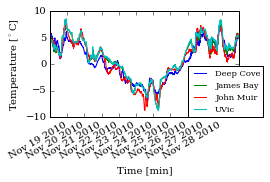

In [59]:
#latexify(columns=1)
idx = np.where((mins > 734094.) & (mins < 734105.))[0]

fig, ax = plt.subplots(1,1)
ax.plot_date(mins[idx], dc[idx], '-b', label='Deep Cove')
ax.plot_date(mins[idx], jb[idx], '-g', label='James Bay')
ax.plot_date(mins[idx], jm[idx], '-r', label='John Muir')
ax.plot_date(mins[idx], uv[idx], '-c', label='UVic')
ax.set_ylabel(r'Temperature [$^\circ$C]'); ax.set_xlabel('Time [min]')
lgd = plt.legend(fontsize='small', bbox_to_anchor=[1.15,.52])
fig.autofmt_xdate()
#plt.savefig('figures/min_coldfront.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Lag correlation

In [78]:
def lag_corr(temp1, temp2, lags):
    temp1 -= np.mean(temp1)
    temp2 -= np.mean(temp2)
    cxx = lags*0.
    for ind,tau in enumerate(lags):
        if tau<0:
            cxx[ind] = np.mean(temp1[tau:]*temp2[:-tau])
        elif tau==0:
            cxx[ind] = np.mean(temp1*temp2)
        else:
            cxx[ind] = np.mean(temp1[:-tau]*temp2[tau:])
    rho = cxx/(np.std(temp1)*np.std(temp2))
    return rho

#latexify(columns=1)

def lag_plot(lags, rho1, rho2, label1, label2, saveas=None, printout=True, lgnd=False):
    plt.plot(lags, rho1, label=label1)
    plt.plot(lags, rho2, label=label2)
    i1 = np.argmax(rho1)
    i2 = np.argmax(rho2)
    if printout:
        print '{} peak at {}'.format(label1, lags[i1])
        print '{} peak at {}'.format(label2, lags[i2])
    plt.scatter(lags[i1], rho1[i1], marker='x', color='k')
    plt.scatter(lags[i2], rho2[i2], marker='x', color='k')
    plt.xlabel(r'Lag, $\tau [min]$') ; plt.ylabel('Lag correlation')
    plt.tight_layout()
    if lgnd:
        lgd = plt.legend(bbox_to_anchor=[1.03,1.4])
        if saveas is not None:
            plt.savefig(saveas, bbox_extra_artists=(lgd,), bbox_inches='tight')
    elif saveas is not None:
        plt.savefig(saveas)
    plt.show()

James Bay, Deep Cove peak at 33.0
John Muir, James Bay peak at 8.0


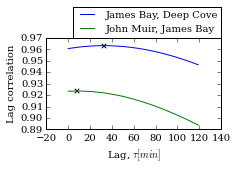

In [79]:
dt = 1.
n = 24.*5.  # Three days
lags = np.arange(0,int(dt*n))

rho_jbdc = lag_corr(jb, dc, lags)
rho_jmjb = lag_corr(jm, jb, lags)
lag_plot(lags/dt, rho_jbdc, rho_jmjb, 'James Bay, Deep Cove', 'John Muir, James Bay', lgnd=True)#, saveas='figures/min_lagcorr.png')

James Bay, Deep Cove peak at 14.0
John Muir, James Bay peak at 1.0


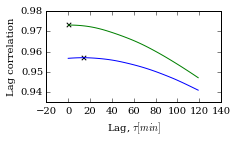

In [81]:
idx = np.where((mins > 734094.) & (mins < 734105.))[0]
rho_jbdc_wf = lag_corr(jb[idx], dc[idx], lags)
rho_jmjb_wf = lag_corr(jm[idx], jb[idx], lags)
lag_plot(lags/dt, rho_jbdc_wf, rho_jmjb_wf, 'James Bay, Deep Cove', 'John Muir, James Bay')#, saveas='figures/min_lagcorr_wf.png')

In [68]:
def seasons(data, dt=1.):  # default is units of hours
    season = 24*30*3*dt
    year = 24*356*dt

    #data_w = np.mean(np.hstack([data[:season], data[year:season+year], data[2*year:2*(season+year)]]))
    #data_s = np.mean(np.hstack([data[2*season:3*season], data[year+2*season:3*season+year], 
    #                     data[2*year+2*season:3*season+2*year]]))
    
    data_w = data[:season]
    data_s = data[2*season:3*season]
    return data_s, data_w

James Bay, Deep Cove peak at 26.0
John Muir, James Bay peak at 15.0


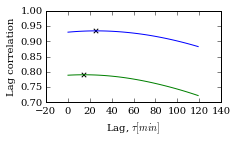

James Bay, Deep Cove peak at 33.0
John Muir, James Bay peak at 16.0


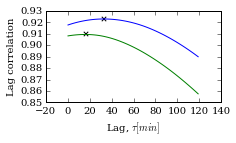

In [82]:
dc_s, dc_w = seasons(dc,60)
jb_s, jb_w = seasons(jb,60)
jm_s, jm_w = seasons(jm,60)

rho_jbdc_s = lag_corr(jb_s, dc_s, lags)
rho_jmjb_s = lag_corr(jm_s, jb_s, lags)
lag_plot(lags/dt, rho_jbdc_s, rho_jmjb_s, 'James Bay, Deep Cove', 'John Muir, James Bay')#, saveas='figures/min_lagcorr_s.png')

rho_jbdc_w = lag_corr(jb_w, dc_w, lags)
rho_jmjb_w = lag_corr(jm_w, jb_w, lags)
lag_plot(lags/dt, rho_jbdc_w, rho_jmjb_w, 'James Bay, Deep Cove', 'John Muir, James Bay')#, saveas='figures/min_lagcorr_w.png')

# Hourly data

Then use this data set to look for spatial patterns of variability between the stations (i.e. calculate the Emperical Orthonormal Eigienfunctions, or Principal Components). Plot the strongest modes of variability and indicate what fraction of the variance they represent. Plotting time series of the modal amplitudes is also very effective way of thinking about the system.

Again, spend a couple of paragraphs explaining the patterns you found, and indicate if those patterns might have a physical meaning. Looking at the seasonality of the amplitudes may help.

In [10]:
# Coastline
# 1 degree of latitude is 60 nautical miles, but 1 degree of longitude is only 60*cos(lat) 
# nautical miles, so it is useful to scale your x and y axis so the aspect ratio is 
# [1 cos(lat)], where "lat" is some latitude that is on the center of your plot. This area 
# is small enough that this approximation will be good enough - for larger areas you need 
# to choose a projection from a sphere onto a map (i.e. the "Mercator", "Azimuthal" etc projections).
coastfile = '/Users/kawebb/P411_git/Coast.txt'  # longitudes followed by latitudes
coasts = np.loadtxt(coastfile)
cstlng = coasts[:len(coasts)/2]
cstlat = coasts[len(coasts)/2:]

In [11]:
# Hourly data, many stations
# One-hour resolution temperature data is taken from the same network of 35 stations. 
# Data is on an even time grid, from 2009-01-01 08:00 UTC, with each row representing 
# a time, and each column a station. The first two rows are the longitude (degrees E) 
# and latitude (degrees N) of each station.
hourfile = '/Users/kawebb/P411_git/AllHourly.txt'
hourdata = np.loadtxt(hourfile)
data = hourdata[:,2:]
lng = hourdata[:,:1][:,0] - 360.  # -360 to fix that stations (0 to 360), coast (-180, 180).
lat = hourdata[:,1:2][:,0]

In [12]:
# john muir, james bay, uvic, deep cove
minlat = [48.3707, 48.4169, 48.4634, 48.6804]
minlng = [-123.752, -123.38, -123.314, -123.457]

In [13]:
### Make hour data
# The data sets start on 1 Jan 2009 a minute after midnight local, or at 08:00 UTC = 733408.333.
d = datetime.date(2012,1,1)
tstart = 733408.333
hours = np.arange(tstart, tstart+len(data[0])/24., 1./24.)  # step size is every hour
d.fromordinal(int(hours[0])), d.fromordinal(int(hours[-1]))  # three years worth of data

### First three measurements for all stations are nan, remove
data = data[:,3:]
hours = hours[3:]

### Handling nan values, identifying stations with not enough data

In [14]:
stable = pd.read_csv('schools.txt', delimiter=' & ', engine='python')
slng = stable.slng.values
slat = stable.slat.values


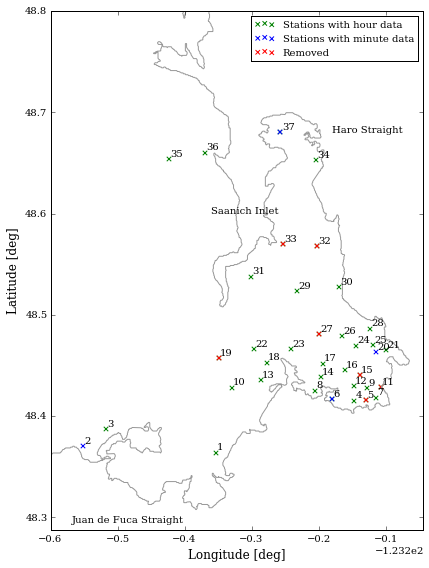

In [9]:
### Plot stations, label those with hour data, minute data, and which we remove

latexify(columns=2)
fig, axs = plt.subplots(figsize=(8,8))
axs.plot(cstlng, cstlat, '-', color='0.6')
axs.scatter(lng, lat, marker='x', color='g', label='Stations with hour data')
axs.scatter(minlng, minlat, marker='x', color='b', label='Stations with minute data')
ix = [0, 11, 16, 19, 22, 23, 34]
axs.scatter(lng[ix], lat[ix], marker='x', color='r', label='Removed')

os = 0.003
for i in stable.index.values:
    axs.text(slng[i]+os, slat[i]+os, i+1, fontsize=10)
    
axs.text(-123.77, 48.295, 'Juan de Fuca Straight')
axs.text(-123.38, 48.68, 'Haro Straight')
axs.text(-123.56, 48.6, 'Saanich Inlet')

axs.set_xlabel(r'Longitude [deg]', fontsize=12) ; axs.set_ylabel(r'Latitude [deg]', fontsize=12)
axs.set_xlim(np.min(cstlng)+0.2, np.max(cstlng)+0.02)
axs.set_ylim(np.min(cstlat)-0.02, 48.8)
axs.set_aspect(1/np.cos(48.6*np.pi/180.))
plt.tight_layout()
plt.legend(loc=0)#, fontsize='small')
#plt.savefig('figures/map_stations.png')
plt.show()

In [15]:
### Ignore data missing long spans of time

# 0, 11, 16, 19, 22, 23, 34 - missing lots
# 8, 10, 14, 17, 25, 30, 31 - missing a few months maybe

# Valid stations
ii = range(1,11)+range(12,16)+range(17,19)+range(20,22)+range(24,34)
data = data[ii,:]
lng = lng[ii]
lat = lat[ii]

tree = spatial.KDTree(zip(lng.ravel(), lat.ravel()))
radius = 0.05  # in degrees
coords = np.dstack([lng, lat])[0]

def interp(data):
    # 1d interpolation to fill in nan values
    ok = -np.isnan(data)
    xp = ok.ravel().nonzero()[0]
    fp = data[-np.isnan(data)]
    x  = np.isnan(data).ravel().nonzero()[0]
    data[np.isnan(data)] = np.interp(x, xp, fp)
    return data

def interp_nn(data, coords, tree, radius, rmean=False):
    
    # Nearest neighbour search for interpolation
    # replace value with average of neighbours
    # MAKE SURE TO ADJUST WEIGHTING TO NEAREST NEIGHBOURS **********
    # ^^^ never did but good enough

    for i in range(data.shape[0]):  # iterate through stations      
        idxs = tree.query_ball_point(coords[i], radius)
        if len(idxs) < 1:
            print 'STOP'
        nearby = data[idxs]
        nans = np.where(np.isnan(data[i]))
        for j in nans[0]:
            data[i,j] = np.nanmean(nearby[:,j])
        nans = np.where(np.isnan(data[i]))
        if len(nans) > 0:
            data[i,:] = interp(data[i,:])
        if rmean:
            data[i,:] -= np.mean(data[i,:])
    return data

data = interp_nn(data, coords, tree, radius, rmean=False)

/Users/kawebb/venv/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


In [9]:
ii = 0
for i in range(35):
    if i in ix:
        print i, np.nan
        ii += 1
    else:
        print i, i-ii

0 nan
1 0
2 1
3 2
4 3
5 4
6 5
7 6
8 7
9 8
10 9
11 nan
12 10
13 11
14 12
15 13
16 nan
17 14
18 15
19 nan
20 16
21 17
22 nan
23 nan
24 18
25 19
26 20
27 21
28 22
29 23
30 24
31 25
32 26
33 27
34 nan


## 2D Interpolations

### Import mask to remove values over water. Fix incorrect values.

In [16]:
mask = np.loadtxt('coastline_mask2.txt')  # array of 1's and nan's. switch values.
mask[np.isnan(mask)] = 0.              
mask[np.where(mask > 0.)] = np.nan
mask[~np.isnan(mask)] = 1. 

/Users/kawebb/venv/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)
/Users/kawebb/venv/lib/python2.7/site-packages/matplotlib/axes/_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/Users/kawebb/venv/lib/python2.7/site-packages/matplotlib/axes/_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):
/Users/kawebb/venv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


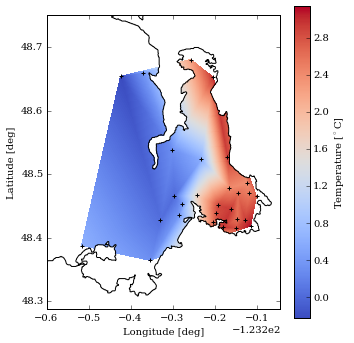

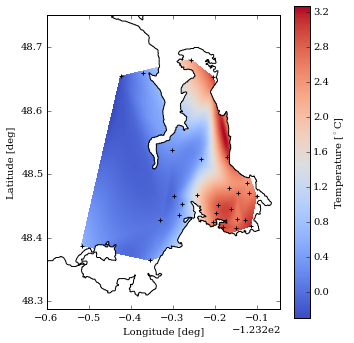

In [17]:
#latexify(columns=1)

# Make grid - Smallest distance between points is lateral, 0.234 deg
# np.meshgrid makes a MxN array out of x (N-vector) and y (M-vector)
xi = np.linspace(-123.2, -123.8, 1000)
yi = np.linspace(48.3, 48.7, 1000)
gridx, gridy = np.meshgrid(xi, yi)

z = data[:,1]  # one measurement for all stations

def temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, temp, mask=None):
    fig, axs = plt.subplots(1,1, figsize=(5,5))
    axs.plot(cstlng, cstlat, '-k')
    if mask is not None:
        gridx = gridx*mask
        gridy = gridy*mask
    pcm = plt.pcolormesh(gridx, gridy, np.ma.masked_invalid(temp), cmap='coolwarm')
    axs.scatter(lng, lat, marker='+', color='k')
    axs.set_xlabel(r'Longitude [deg]') ; axs.set_ylabel(r'Latitude [deg]')
    axs.set_xlim(np.min(cstlng)+0.2, np.max(cstlng)+0.02)
    axs.set_ylim(np.min(cstlat)-0.02, 48.75)
    axs.set_aspect(1/np.cos(48.6*np.pi/180.))
    plt.colorbar(label=r'Temperature [$^\circ$C]')
    plt.tight_layout()
    #plt.show()
    return fig
    
zi = mlab.griddata(lng, lat, z, xi, yi, interp='linear')
temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi, mask) ; plt.show()

# NN interpolation wont work because grid not regular monotonically increasing
#zi = mlab.griddata(lng, lat, z, xi, yi, interp='nn')
#temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi, mask)

zi = interpolate.griddata(np.vstack((lng,lat)).T, z, (gridx,gridy), method='cubic')
temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi, mask) ; plt.show()

### Annual, Winter, Summer mean temperatures

In [227]:
zi_mean = interpolate.griddata(np.vstack((lng,lat)).T, np.mean(data, axis=1), (gridx,gridy), method='cubic')
zi_std = interpolate.griddata(np.vstack((lng,lat)).T, np.std(data, axis=1), (gridx,gridy), method='cubic')

season = 24*30*3
year = 24*356

data_winter = np.mean(np.hstack([data[:,:season], data[:,year:season+year], data[:,2*year:2*(season+year)]]), axis=1)
data_winterstd = np.std(np.hstack([data[:,:season], data[:,year:season+year], data[:,2*year:2*(season+year)]]), axis=1)

data_summer = np.mean(np.hstack([data[:,2*season:3*season], data[:,year+2*season:3*season+year], 
                         data[:,2*year+2*season:3*season+2*year]]), axis=1)
data_summerstd = np.std(np.hstack([data[:,2*season:3*season], data[:,year+2*season:3*season+year], 
                         data[:,2*year+2*season:3*season+2*year]]), axis=1)

zi_winter = interpolate.griddata(np.vstack((lng,lat)).T, data_winter, (gridx,gridy), method='cubic')
zi_winterstd = interpolate.griddata(np.vstack((lng,lat)).T, data_winterstd, (gridx,gridy), method='cubic')
zi_summer = interpolate.griddata(np.vstack((lng,lat)).T, data_summer, (gridx,gridy), method='cubic')
zi_summerstd = interpolate.griddata(np.vstack((lng,lat)).T, data_summerstd, (gridx,gridy), method='cubic')

In [228]:
np.mean(data_summer), np.std(data_summer), np.mean(data), np.std(data), np.mean(data_winter), np.std(data_winter)

(16.004626751648924,
 0.71194027920523195,
 9.8772747448078491,
 5.7362627706219467,
 6.1016915605144408,
 0.62195061787286343)

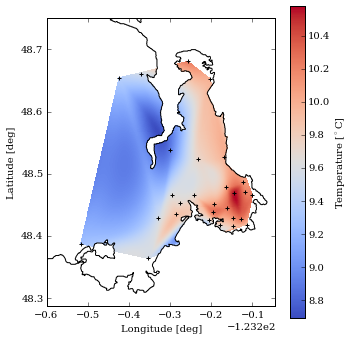

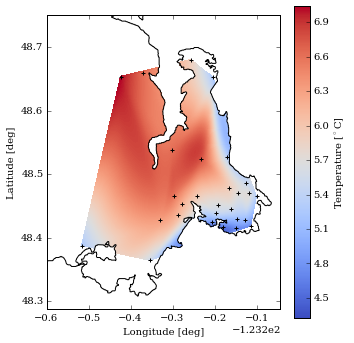

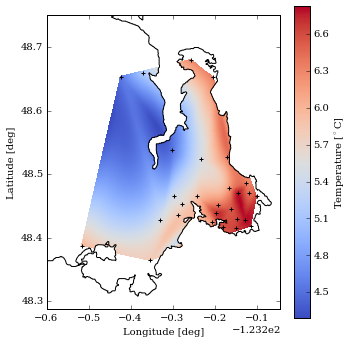

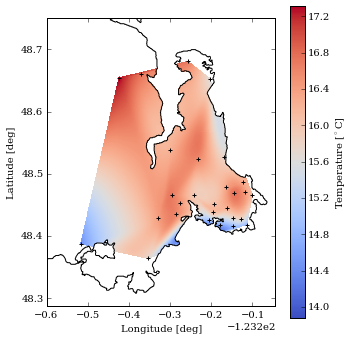

In [230]:
#latexify(columns=1)

temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi_mean, mask)
#plt.savefig('figures/hour_meanannual.png')
plt.show()

temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi_std, mask)
#plt.savefig('figures/hour_meanannualstd.png')
plt.show()

temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi_winter, mask)
#plt.savefig('figures/hour_meanwinter.png')
plt.show()

#temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi_winterstd, mask)
#plt.savefig('figures/hour_meanwinterstd.png')
#plt.show()

temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi_summer, mask)
#plt.savefig('figures/hour_meansummer.png')
plt.show()

#temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi_summerstd, mask)
#plt.savefig('figures/hour_meansummerstd.png')
#plt.show()

## Look for spatial patterns in the data using empiracle orthogonal functions

### 2d plot temperature as modes

In [18]:
rmdata = np.zeros_like(data)
for i in range(np.shape(data)[1]):
    rmdata[:,i] = data[:,i] - np.mean(data[:,i])

np.shape(rmdata)

(28, 26277)

In [19]:
def eof(temp):
    C = np.cov(temp)
    Cp , E = np.linalg.eig(C)  # eigenvalues, eigenvectors
    # temp2 = np.dot(np.linalg.inv(E), temp)
    for i in range(np.shape(E)[1]):
        ii = np.argmax(np.abs(E[:,i]))
        E[:,i] = E[:,i] / E[ii,i]
    modes = np.dot(np.linalg.inv(E), temp)

    return modes, E, Cp
    
modes, E, Cp = eof(rmdata)

In [26]:
def mode_plot(time, modes, Cp, start=0, end=-1, m=0):
    fig, ax = plt.subplots()
    ax.plot_date(time[start:end], modes[m,start:end], '-b')
    fig.autofmt_xdate()
    ax.set_xlabel('Time [hour]') ; ax.set_ylabel(r'Temperature [$^\circ$C]')
    ax.set_ylim(np.min(modes[m,start:end]), np.max(modes[m,start:end]))
    plt.tight_layout()
    print 'Mode {} includes {} percent of the variance'.format((m+1),Cp[m]/np.sum(Cp)*100.)

first one has highest amplitude
see which ones also have high amplitudes

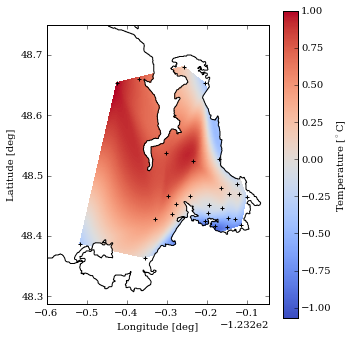

Mode 1 includes 44.8185131234 percent of the variance


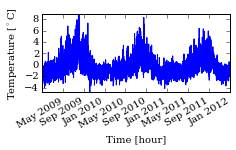

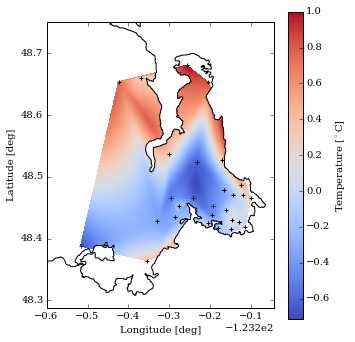

Mode 2 includes 10.8828969619 percent of the variance


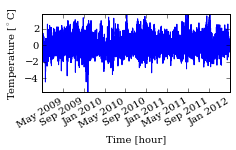

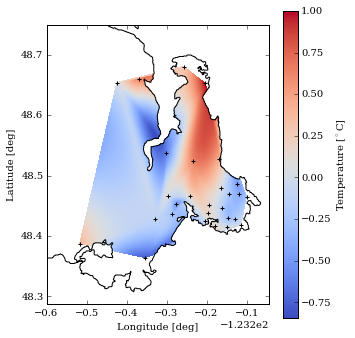

Mode 3 includes 7.05480071936 percent of the variance


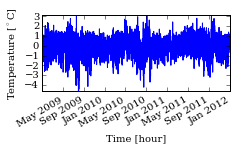

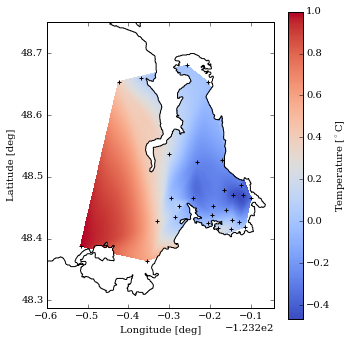

Mode 4 includes 6.44539100922 percent of the variance


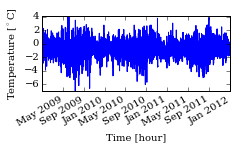

In [29]:
#latexify(columns=1)
for m in range(0,4):
    zi = interpolate.griddata(np.vstack((lng,lat)).T, E[:,m], (gridx,gridy), method='cubic')
    temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi, mask)
    plt.savefig('figures/hour_mode{}map.png'.format(m))
    plt.show()
    mode_plot(hours, modes, Cp, start=0, end=-1, m=m)
    #plt.savefig('figures/hour_mode{}ts.png'.format(m))
    plt.show()

## Spectrogram

/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


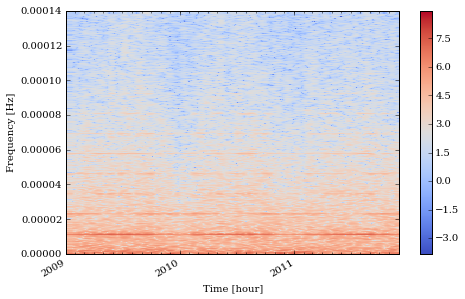

In [237]:
#latexify(columns=2)

N = data.shape[1]
t = np.arange(N)
dt2 = np.median(np.diff(t))
NN = 24.  # This is just the window size, for small window size, remove high f ?
n = int(np.floor(N/NN))
nn = 12.  # arbitrarily chosen, same as notes

Nfft = np.shape(data)[1]/24
dt = 60.*60.   # Assignment 4 uses 60*60
args = {'NFFT':Nfft, 'Fs':1./dt, 'noverlap':Nfft/2., 'window':mlab.window_hanning}

gxx = np.zeros((N*nn, Nfft/2+1))
tbin = np.zeros(N*nn)

num = 0
temp = np.mean(data, axis=0)

for idx in np.arange(0, N-n, int(np.floor(n/nn))):
    px, f = np.squeeze( mlab.psd(temp[idx+np.arange(n)], **args))
    gxx[num,:] = px
    num += 1
    tbin[num] = np.mean(t[idx+np.arange(n)])

tbin = tbin[:num]
gxx = gxx[:num, :]

fig,axs = plt.subplots(1,1)
pcm = axs.pcolormesh(tbin/24.+733408, f, np.log10(gxx.T), cmap='coolwarm')
plt.xlim(tbin[0]/24.+733408, tbin[-1]/24.+733408)
fig.colorbar(pcm,ax=axs)
plt.xlabel('Time [hour]')
plt.ylabel('Frequency [Hz]')
# do things to make date axis look nice
axs.xaxis.set_major_locator( dates.YearLocator())
axs.xaxis.set_major_formatter( dates.DateFormatter('%Y'))
axs.xaxis.set_minor_locator(dates.MonthLocator())

fig.autofmt_xdate()
plt.tight_layout()
#plt.savefig('figures/hour_spec.png')
plt.show()


In [3]:
SPINE_COLOR = 'gray'
def latexify(fig_width=None, fig_height=None, columns=1):
    """
    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """
    assert(columns in [1,2])
    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches
    if fig_height is None:
        golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches
    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES
    params = {'backend': 'ps',
              #'text.latex.preamble': ['\usepackage{gensymb}'],
              'axes.labelsize': 10, # fontsize for x and y labels (was 10)
              'axes.titlesize': 10,
              'text.fontsize': 10, # was 10
              'legend.fontsize': 10, # was 10
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              #'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }
    rcParams.update(params)
    
def format_axes(ax, xlabel, ylabel):
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)
    return ax